In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import (Dense, Reshape, Flatten, Dropout, BatchNormalization,
                                     Conv2D, Conv2DTranspose, LeakyReLU, ReLU)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Input
from tensorflow.keras import layers
import zipfile
import time
import gc
from IPython.display import clear_output

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load Data
Since we are given two datasets, lets load in both and keep them separate

In [23]:
# Load and preprocess the dataset
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def prepare_dataset(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(3)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [24]:
# Load the datasets
monet_filenames = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_filenames = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

monet_dataset = load_dataset(monet_filenames)
photo_dataset = load_dataset(photo_filenames)

monet_dataset = prepare_dataset(monet_dataset)
photo_dataset = prepare_dataset(photo_dataset)

# Sample images for visualization
sample_monet = next(iter(monet_dataset))
sample_photo = next(iter(photo_dataset))

Example of photo and monet

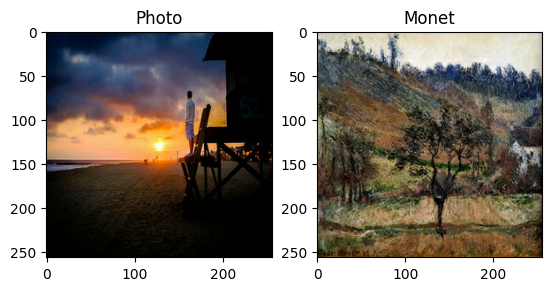

In [25]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

## Generator

In [26]:
# Define the generators and discriminators
def instance_norm(epsilon=1e-5):
    return tf.keras.layers.LayerNormalization(epsilon=epsilon, center=True, scale=True)

Use Downsample to reduce the 2D dimensions by the stride. 

In [27]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(instance_norm())

    result.add(layers.LeakyReLU())

    return result

Upsample will establish skip connections whihc will help bypass vanishing gradient problems.

In [28]:
def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))

    result.add(instance_norm())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Create the generator

In [29]:
def generator():
    inputs = layers.Input(shape = [256, 256, 3])
    
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer = initializer, activation = 'tanh')
    
    x = inputs
    
    # Downloading
    skips = [] 
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[: -1])
    
    # Upsampling
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return keras.Model(inputs = inputs, outputs = x)

## Discriminator
Create the discriminator

In [30]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
    
    inp = layers.Input(shape = [256, 256, 3], name = 'input image')
    
    x = inp
    
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4, False)(down1)
    down3 = downsample(256, 4, False)(down2)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer, use_bias = False)(zero_pad1)
    
    norm1 = instance_norm()(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(zero_pad2)
    
    return tf.keras.Model(inputs = inp, outputs = last)

Create the Models that will be used for generating and discriminating

In [31]:
# models
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

# loss function
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [32]:
def discrim_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def gen_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 30 * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 30 * 0.5 * loss

In [33]:
# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


In [39]:
epochs = 3

def generate_img(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize = (12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        # get pixel value between [0, 1] to plot
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [40]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = gen_loss(disc_fake_y)
    gen_f_loss = gen_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discrim_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discrim_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


Go through, and visualize the monet output for a sample photo based on the training we have done above

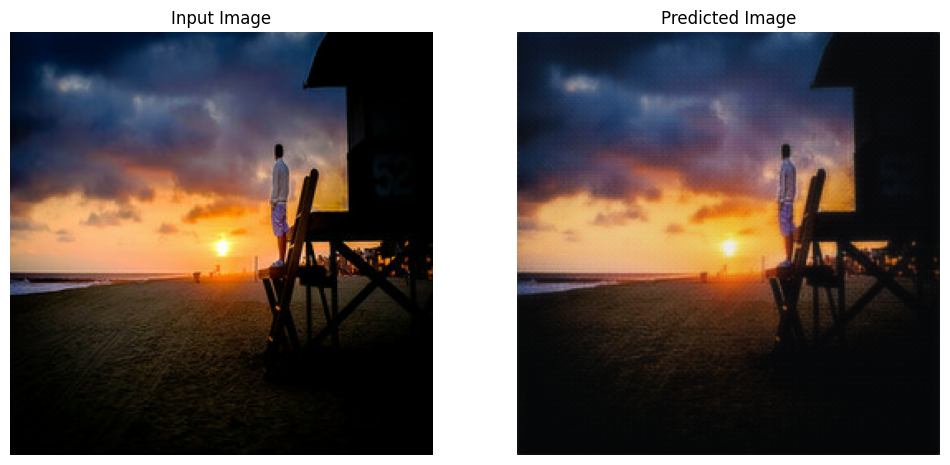

Time taken for epoch 3 is 73.43551993370056 sec



In [41]:
for epoch in range(epochs):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((monet_dataset, photo_dataset)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_photo) so that the progress of the model
    # is clearly visible.
    generate_img(generator_g, sample_photo)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))


## Submission

Upload 7000 images to images.zip for submission

In [17]:
import os
import numpy as np
from PIL import Image
import zipfile

# Directory to save generated images
output_dir = 'images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Number of images you want to generate
total_images = 7000
batch_size = 50  # Adjust based on memory constraints
images_generated = 0

# Assuming `photo_dataset` is already defined as a dataset of input photos
for batch in photo_dataset.batch(batch_size):
    if images_generated >= total_images:
        break

    # Check if the batch shape is correct (batch_size, 256, 256, 3)
    if batch.shape[1] == 3:
        batch = tf.reshape(batch, (-1, 256, 256, 3))
        
    
    # Generate Monet-style images using the generator model
    gen_imgs = generator_g(batch)  # Apply style transfer to input images

    # Rescale images from [-1, 1] to [0, 255] and convert to uint8 format
    gen_imgs = (0.5 * gen_imgs + 0.5) * 255
    gen_imgs = gen_imgs.numpy().astype(np.uint8)
    
    # Save each generated image
    for i in range(gen_imgs.shape[0]):
        img = Image.fromarray(gen_imgs[i])
        img.save(f"{output_dir}/image_{images_generated + i + 1}.png")
    
    images_generated += gen_imgs.shape[0]
    print(f"Generated {images_generated}/{total_images} images.")

# Zip all the images into a zip file for submission
zip_filename = "images.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as img_zip:
    for filename in os.listdir(output_dir):
        img_zip.write(os.path.join(output_dir, filename), arcname=filename)

print(f"All images have been generated and zipped into {zip_filename}.")


Generated 150/7000 images.
Generated 300/7000 images.
Generated 450/7000 images.
Generated 600/7000 images.
Generated 750/7000 images.
Generated 900/7000 images.
Generated 1050/7000 images.
Generated 1200/7000 images.
Generated 1350/7000 images.
Generated 1500/7000 images.
Generated 1650/7000 images.
Generated 1800/7000 images.
Generated 1950/7000 images.
Generated 2100/7000 images.
Generated 2250/7000 images.
Generated 2400/7000 images.
Generated 2550/7000 images.
Generated 2700/7000 images.
Generated 2850/7000 images.
Generated 3000/7000 images.
Generated 3150/7000 images.
Generated 3300/7000 images.
Generated 3450/7000 images.
Generated 3600/7000 images.
Generated 3750/7000 images.
Generated 3900/7000 images.
Generated 4050/7000 images.
Generated 4200/7000 images.
Generated 4350/7000 images.
Generated 4500/7000 images.
Generated 4650/7000 images.
Generated 4800/7000 images.
Generated 4950/7000 images.
Generated 5100/7000 images.
Generated 5250/7000 images.
Generated 5400/7000 images

In [18]:
print(generator_g.input_shape)

(None, 256, 256, 3)


## References  
https://keras.io/examples/generative/cyclegan/#building-blocks-used-in-the-cyclegan-generators-and-discriminators  
https://www.tensorflow.org/tutorials/generative/cyclegan#checkpoints  
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Build-the-generator

## Conclusion
The project successfully implemented a GAN to generate Monet style images through a dataset of photos. This project demonstrated the power of GANs in creative tasks, while also highlighting key challenges in memory management shape compatability. Overall it was a fascinating learning experience.

In [20]:
'''
import shutil
# Deleting the old zip files
if os.path.exists("/kaggle/working/images.zip"):
    os.remove("/kaggle/working/images.zip")
    
# Deleting the entire 'images' directory
if os.path.exists("/kaggle/working/images"):
    shutil.rmtree("/kaggle/working/images")
'''
